In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings
import matplotlib as mpl

warnings.filterwarnings('ignore')

## Wczytanie danych i preprocesing

Wczytujemy dane (po 1500 dokumentów z każdego pliku), lematyzujemy słowa i usuwamy "stop word'sy".

In [2]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def read_and_preprocess(name, index=0):
    df = pd.DataFrame(columns=[0, 1, 2])
    i = 0
    for chunk in pd.read_csv(f"docword.{name}.txt.gz", compression='gzip', sep=' ', header=None, skiprows=3, chunksize=1000):
        df = pd.concat([df, chunk])
        if (chunk[chunk[0] > 1500][0].any()):
            df = df[df[0] < 1501]
            break
    df.columns = ['docID', 'wordID', 'count']
    df.docID = df.docID + index
    vb = pd.read_csv(f"vocab.{name}.txt", header=None, delim_whitespace=True) 
    vb[0] = vb[0].astype(str)
    vb.loc[:,0] = vb.loc[:,0].apply(lambda x: '-1' if nlp(x)[0].is_stop else nlp(x)[0].lemma_)
    vb.index = vb.index + 1
    dct = vb[0].to_dict()
    
    df['wordID'] = df['wordID'].map(dct)
    df = df[df['wordID'] != '-1']
    
    df['type'] = name
    return df

In [3]:
names = ['pubmed', 'nytimes', 'kos', 'enron', 'nips']
index = 0
data = pd.DataFrame(columns=['docID', 'wordID', 'count'])

for i in names:
    df = read_and_preprocess(i, index)
    data = pd.concat([data, df])
    index += 1500

In [4]:
data['wordID'].nunique()

40753

In [5]:
data = data.groupby(['docID','wordID', 'type'],as_index=False).agg({'count': 'sum'})

Nasza ramka po wstępnym wczytaniu zawiera nr dokumentu, słowo, źródło skąd był dokument oraz liczbę wystąpień danego słowa w dokumencie.

In [6]:
data

,docID,wordID,type,count
0,1,accompany,pubmed,1
1,1,appear,pubmed,1
2,1,area,pubmed,1
3,1,breast,pubmed,1
4,1,cancer,pubmed,3
...,...,...,...,...
1281109,7500,zemel,nips,1
1281110,7500,zhang,nips,3
1281111,7500,zhaope,nips,1
1281112,7500,ziehe,nips,1


Tworzymy ramkę pomocniczą w celu odfiltrowania słów, które występują mniej niż 10 razy oraz słów, które składają się z samych cyfr bądź są na tyle krótkie (2-3 dowolne znaki), że nic nie wniosą do naszego modelu.

In [7]:
pom = data.groupby('wordID').count().reset_index()

In [8]:
pom = pom[['wordID', 'count']]

In [9]:
pom = pom[pom['count'] >= 10]

In [10]:
pom = pom[pom['wordID'].str.findall("^.{1,2}\d?$").str.len() == 0]
pom = pom[pom['wordID'].str.findall("^.{1,2}$").str.len() == 0]
pom = pom[pom['wordID'].str.findall(".*\\d+.*").str.len() == 0]

In [11]:
data = data[data['wordID'].isin(list(pom['wordID']))]

In [12]:
data

,docID,wordID,type,count
0,1,accompany,pubmed,1
1,1,appear,pubmed,1
2,1,area,pubmed,1
3,1,breast,pubmed,1
4,1,cancer,pubmed,3
...,...,...,...,...
1281108,7500,young,nips,1
1281109,7500,zemel,nips,1
1281110,7500,zhang,nips,3
1281111,7500,zhaope,nips,1


In [13]:
data.nunique()

docID      7500
wordID    11526
type          5
count       124
dtype: int64

In [14]:
tmp = data.groupby('docID')['type'].max()

In [15]:
tmp.head()

docID
1    pubmed
2    pubmed
3    pubmed
4    pubmed
5    pubmed
Name: type, dtype: object

In [16]:
data.loc[:, "count"] = pd.to_numeric(data.loc[:, "count"])

Tworzymy `sparse matrix`, aby nasza ramka mieściła się do pamięci.

In [17]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

def create_sparse_matrix(df):
    docID_c = CategoricalDtype(sorted(df.docID.unique()), ordered=True)
    wordID_c = CategoricalDtype(sorted(df.wordID.unique()), ordered=True)

    row = df.docID.astype(docID_c).cat.codes
    col = df.wordID.astype(wordID_c).cat.codes
    sparse_matrix = csr_matrix((df["count"], (row, col)), \
                               shape=(docID_c.categories.size, wordID_c.categories.size))
    return sparse_matrix, docID_c, wordID_c

In [18]:
word_matrix, doc, wor = create_sparse_matrix(data)

In [19]:
word_matrix

<7500x11526 sparse matrix of type '<class 'numpy.int64'>'
	with 1198517 stored elements in Compressed Sparse Row format>

Następnie naszą macierz transformujemy, aby była przedstawiona w formacie `tf-idf`.

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
word_matrix = tfidf.fit_transform(word_matrix)

## Wizualizacja danych (TSNE)

W celu wizualizacji naszych danych zdecydowaliśmy się na algorytm **TSNE**.

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state = 42, n_components=2, perplexity=50, n_iter=1000, verbose = 0).fit_transform(word_matrix)

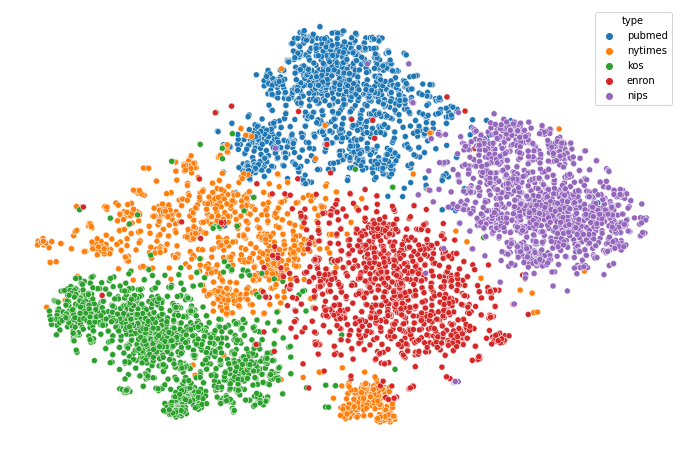

In [22]:
plt.figure(figsize=(12,8))
sns.scatterplot(x =tsne[:, 0], y = tsne[:, 1], hue = tmp)
plt.axis("off")
plt.show()

Z wykresu możemy dostrzec że nasze dane są skupione w wielkiej 'chmurze' (w której są przerwy), lecz bez kolorów ciężko by było nam dostrzeć 5 podgrup.

## Redukcja wymiarów

Zredukowaliśmy rozmiar naszej macierzy do 2000 kolumn z ponad 11000. Wybraliśmy taką liczbę aby zachowane było przynajmniej 80% wariancji.

In [23]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(batch_size=2000)
data_pca = pca.fit_transform(word_matrix)

In [24]:
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))


 Total Variance Explained: 82.65


# Klasteryzacja 

Aby sklasteryzować nasze dane postanowiliśy wypróbować dwa popularne i sprawdzone algorytmy: KMeans i Gaussian Mixture.

## K-means

W celu wybrania optymalnej liczby klastrów dla algorytmu KMeans zdecydowaliśmy się użyć metody łokciowej i zbadać silhouette score.

In [25]:
from sklearn.cluster import KMeans

In [26]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data_pca)
                for k in range(1, 20)]
inertias = [model.inertia_ for model in kmeans_per_k]

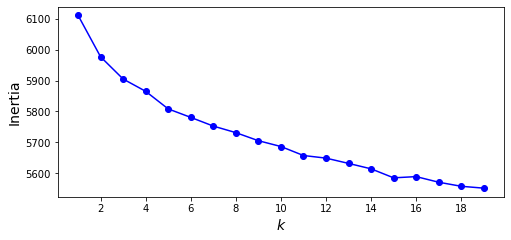

In [27]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 20), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.xticks(np.arange(2, 20, step=2))
plt.show()

Niestety, na wykresie inercji ciężko znaleźć punkt który można by uznać za "zgięcie łokcia". Musimy zatem w całości polegać na silhouette score.

In [28]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(data_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

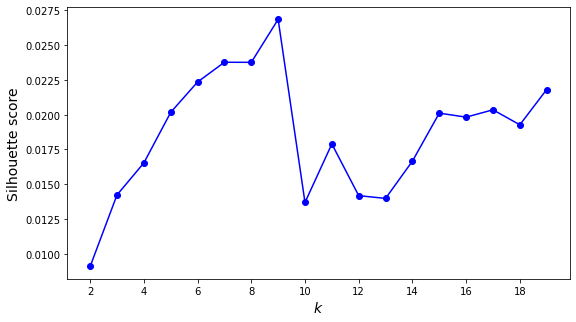

In [29]:
plt.figure(figsize=(9, 5))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.xticks(np.arange(2, 20, step=2))
plt.show()

Jak widać na powyższym wykresie silhouette score jest najwyższy dla liczby klastrów równej 9 zatem zdecydujemy się właśnie na taką liczbę.

In [30]:
kmeans = KMeans(n_clusters=9, verbose=0, random_state=42)

In [31]:
kmeans_labels = kmeans.fit_predict(data_pca)

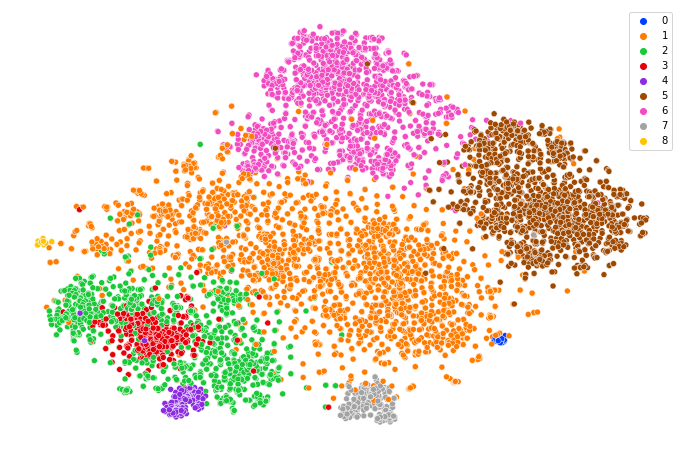

In [32]:
plt.figure(figsize=(12,8))
sns.scatterplot(x =tsne[:, 0], y = tsne[:, 1], hue = kmeans_labels, palette='bright')
plt.axis('off')
plt.show()

Korzystając z wykresu TSNE i kolorując po labelach wyprodukowanych przez KMeans możemy porównać jak klastry mają się do tego skąd pochodzą dokumenty.
W następnym kroku postanowiliśmy zobaczyć jakie są najczęściej występujące słowa w danych klastrach, czy mają one sens.

In [33]:
datac = data.copy()

In [34]:
zip_km = zip(list(datac['docID'].unique()), list(kmeans_labels))
dict_km = dict(zip_km)

In [35]:
datac['km'] = datac['docID'].map(dict_km)

In [36]:
topic_km = datac.groupby(['km', 'wordID'],as_index=False).agg({'count': 'sum'})

In [37]:
topic_km[topic_km['km'] == 1].sort_values(by=['count'], ascending=False).head(10)

,km,wordID,count
1481,1,company,1768
4519,1,look,1190
4654,1,market,1161
1057,1,buy,1156
2940,1,find,1105
5583,1,percent,1060
5707,1,plan,1059
3527,1,high,947
3499,1,help,942
5915,1,price,904


W klasterze o numerze 1 będącym głównie zlepkiem maili pracowników firmy Enron oraz artykułów z gazety The New York Times najczęściej występujące słowa to m.in. firma, rynek, cena, plan. Prawdopodobnie są to dokumenty poruszające tematy ekonomiczne.

## Gaussian Mixture

Tak jak we wcześniejszym przypadku, dla wybrania dobrej liczby klastrów dla algorymu Gaussian Mixture użyjemy silhouette score.

In [38]:
from sklearn.mixture import GaussianMixture

In [39]:
gm_per_k = [GaussianMixture(n_components=k, n_init = 5, random_state=42, verbose=0).fit(data_pca)
                for k in range(2, 10)]

In [40]:
silhouette_scores = [silhouette_score(data_pca, model.predict(data_pca))
                     for model in gm_per_k]

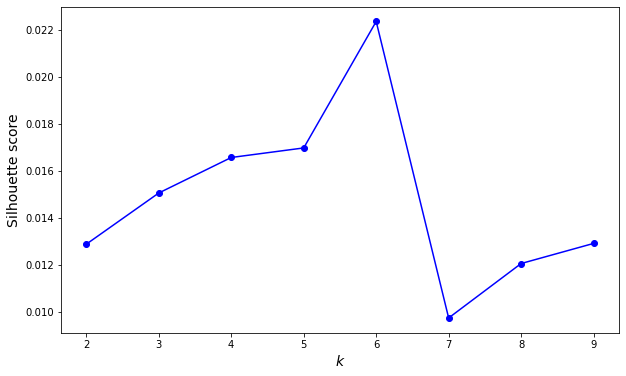

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

Na wykresie powyżej widać że silhouette score jest najwyższy dla liczby klastrów równej 6 zatem użyjemy tej właśnie liczby.

In [42]:
gm = GaussianMixture(n_components=6, n_init=10, random_state=42, verbose=0)
gm.fit(data_pca)

GaussianMixture(n_components=6, n_init=10, random_state=42)

In [43]:
gm_labels = gm.predict(data_pca)

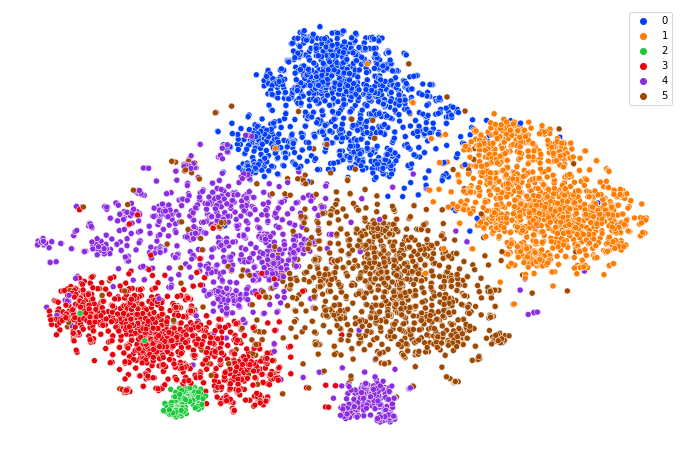

In [44]:
plt.figure(figsize=(12,8))
sns.scatterplot(x =tsne[:, 0], y = tsne[:, 1], hue = gm_labels, palette='bright')
plt.axis('off')
plt.show()

Dokonaliśmy wizualizacji tak jak przy KMeans i również zbadamy najczęściej występujące słowa.

In [45]:
datac = data.copy()

In [46]:
zip_gm = zip(list(datac['docID'].unique()), list(gm_labels))
dict_gm = dict(zip_gm)

In [47]:
datac['gm'] = datac['docID'].map(dict_gm)

In [48]:
topic_gm = datac.groupby(['gm', 'wordID'],as_index=False).agg({'count': 'sum'})

In [49]:
topic_gm[topic_gm['gm'] == 3].sort_values(by=['count'], ascending=False).head(10)

,gm,wordID,count
16169,3,bush,3157
17776,3,kerry,1921
18854,3,republican,1173
17689,3,iraq,1021
19284,3,state,1013
18531,3,poll,993
19783,3,war,941
16898,3,election,937
16191,3,campaign,923
19530,3,time,832


Klaster numer 3 pochodzący w większości z wpisów blogowych składa się najprawdopodobniej z artykułów o wyborach prezydenckich w USA i wojnie w Iraku, która z pewnością była ważnym tematem kampanii wyborczej. Przypuszczalnie był to gorący temat i wiele osób o tym pisało.

### Podsumowanie

- algorytm KMeans zaproponował liczbę klastrów równą 9 a Gaussian Mixture 6.
- w obu przypadkach clusternig wydaje się w miarę poprawny, ciężko stwierdzić na pewno który sprawdził się lepiej
- w przypadku Gaussian Mixture klastry niemal pokrywają się z tym skąd pochodzą dokumenty, jest tylko jeden dodatkowy klaster, więc to on sprawia wrażenie lepszego
- niestety nie mieliśmy tytułów dokumentów co z pewnością ułatwiłoby nam sprawdzenie poprawności dokonanej klasteryzacji